In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(17, 1))
x = layers.Conv1D(8,3, activation='relu', padding='same',dilation_rate=2)(encoder_inputs)
# x = ZeroPadding1D((2,1))(x)
x1 = layers.MaxPooling1D(1)(x)
x2 = layers.Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(x1)
x3 = layers.MaxPooling1D(1)(x2)
x4 = layers.AveragePooling1D()(x3)
flat = layers.Flatten()(x4)
encoder = layers.Dense(2)(flat)
x = encoder
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 17, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 17, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 17, 4)        100         ['max_pooling1d[0][0]']          
                                                                                            

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
#d = layers.Flatten()(latent_inputs)
d1 = layers.Dense(9)(latent_inputs)
#d2 = layers.Reshape((117,4))(d1)
d2 = layers.Reshape((9,1))(d1)
d3 = layers.Conv1D(4,1,strides=1, activation='relu', padding='same')(d2)
d4 = layers.UpSampling1D()(d3)
d5 = layers.Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
#d6 = layers.UpSampling1D(2)(d5)
#d7 = layers.UpSampling1D(2)(d6)
d8 = layers.Conv1D(1,2, strides=1, activation='sigmoid', padding='same')(d5)
decoded = layers.Cropping1D(cropping=(1,0))(d8) # this is the added step
#decoded = d8

decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 27        
                                                                 
 reshape (Reshape)           (None, 9, 1)              0         
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 4)              8         
                                                                 
 up_sampling1d (UpSampling1D  (None, 18, 4)            0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 8)             40        
                                                           

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction)**2, axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
(x_train) = pd.read_csv('train_dataset.csv')
(x_test) = pd.read_csv('test_dataset.csv')

#print(x_train)
#print(x_test)

In [7]:
peptides = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
peptides = np.expand_dims(peptides, -1)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(peptides, batch_size=50, epochs=8)
vae.fit(peptides, batch_size=128, epochs=50)

Epoch 1/50
9/9 [==============================] - 1s 4ms/step - loss: 13511824.1500 - reconstruction_loss: 7492322.5000 - kl_loss: 18936568.0000
Epoch 2/50
9/9 [==============================] - 0s 3ms/step - loss: 7777561.8000 - reconstruction_loss: 7376971.5000 - kl_loss: 339314.7500
Epoch 3/50
9/9 [==============================] - 0s 3ms/step - loss: 7463268.1500 - reconstruction_loss: 7452382.0000 - kl_loss: 7889.4800
Epoch 4/50
9/9 [==============================] - 0s 3ms/step - loss: 7539038.9000 - reconstruction_loss: 7359520.0000 - kl_loss: 3872.4424
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 7459143.7500 - reconstruction_loss: 7381774.5000 - kl_loss: 3719.1533
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 7597475.8500 - reconstruction_loss: 7170191.0000 - kl_loss: 3458.1018
Epoch 7/50
9/9 [==============================] - 0s 3ms/step - loss: 7213980.0500 - reconstruction_loss: 7512449.0000 - kl_loss: 3498.9526
Epoch 8/50
9/

In [8]:
#VIZUALIZACIJA

img_width = 17
img_height = 1
num_channels = 1

def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1])
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()
    
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)[:num_samples]
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

27/27 [==============================] - 0s 1ms/step


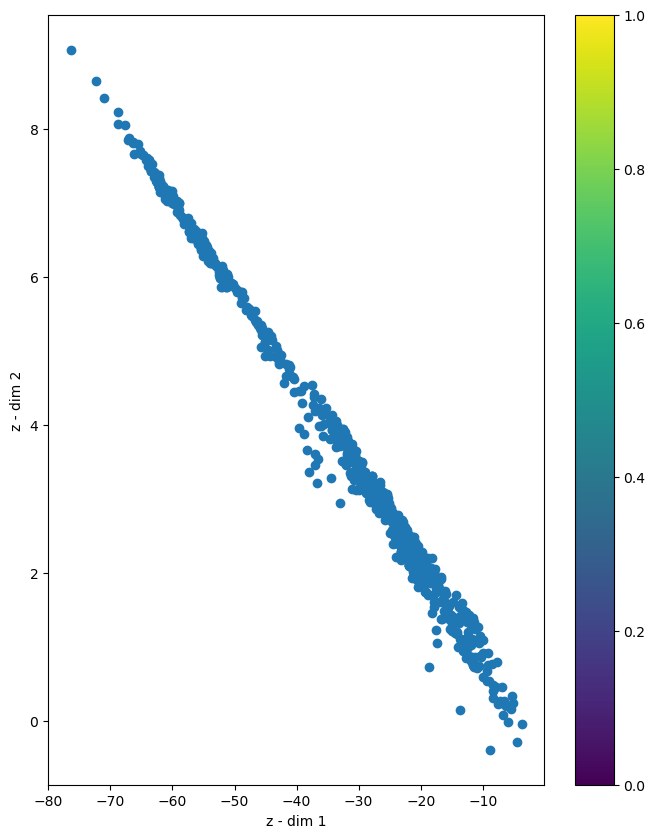

In [9]:
import matplotlib.pyplot as plt

# Plot results
data = (x_train, x_test)
viz_latent_space(encoder, data)

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 2ms/step


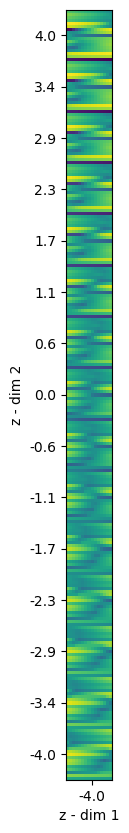

In [10]:
viz_decoded(encoder, decoder, data)